Используя предоставленный набор данных необходимо разработать максимально эффективную скоринговую карту (преимущественно используемый подход в группе компаний - логистическая регрессия)

Событие, на котором необходимо произвести разработку обозначены - risk_event

Как результат - предоставить отчет со значениями: корреляций переменных, gini модели на development и test семплах, accuracy, WOE переменных, раскладку полной выборки согласно разработанной модели

Файл для решения прилагается.

In [1]:
import catboost
import numpy as nm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

import statsmodels.api as sm 
import pandas as pd


from sklearn import model_selection, linear_model, metrics, pipeline, preprocessing 
from sklearn.metrics import roc_auc_score
import category_encoders

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from woe import WoE

In [3]:
df = pd.read_excel('vnabt.xlsx')

In [9]:
df.head()

,application_id,application_date_created,application_week_created,application_month_created,loan_date_created,loan_week_created,loan_month_created,amount_issued,loan_duration,risk_event,...,param_322,param_323,param_324,param_325,param_122_d,param_133_d,param_249_d,param_250_d,param_251_d,param_308_d
0,453055,2020-11-28,2020. 48 week. 23 Nov-29 Nov,2020-11-01,2020-12-01,2020. 49 week. 30 Nov-06 Dec,2020-12-01,1000000,10,0,...,NaN,NaN,NaN,NaN,1004.0,6.0,9239.0,140.0,-257.0,554.0
1,454384,2020-11-29,2020. 48 week. 23 Nov-29 Nov,2020-11-01,2020-12-01,2020. 49 week. 30 Nov-06 Dec,2020-12-01,600000,10,1,...,NaN,NaN,NaN,NaN,1095.0,1.0,9240.0,141.0,-256.0,NaN
2,454971,2020-11-29,2020. 48 week. 23 Nov-29 Nov,2020-11-01,2020-12-01,2020. 49 week. 30 Nov-06 Dec,2020-12-01,800000,10,0,...,NaN,NaN,NaN,NaN,NaN,NaN,9240.0,141.0,-256.0,NaN
3,455036,2020-11-29,2020. 48 week. 23 Nov-29 Nov,2020-11-01,2020-12-01,2020. 49 week. 30 Nov-06 Dec,2020-12-01,800000,10,0,...,NaN,NaN,NaN,NaN,1095.0,2.0,9240.0,141.0,-256.0,NaN
4,455152,2020-11-29,2020. 48 week. 23 Nov-29 Nov,2020-11-01,2020-12-01,2020. 49 week. 30 Nov-06 Dec,2020-12-01,1000000,10,0,...,NaN,NaN,NaN,NaN,152.0,4.0,9240.0,141.0,-256.0,3130.0


In [8]:
df.shape

(6217, 341)

In [128]:
# перевод дат в разницу дней
ddays_cols = ['param_122_d']
df['param_122_d'] = np.nan
df.loc[~df['param_122'].isnull(),'param_122_d'] = ((df[~df['param_122'].isnull()]['application_date_created'] - df[~df['param_122'].isnull()]['param_122'])/np.timedelta64(1, 'D')).astype(int)

ddays_cols += ['param_133_d']
df['param_133_d'] = df['application_date_created'].map(lambda df: df.year)-df['param_133']

ddays_cols += ['param_210_d']
df['param_210_d'] = np.nan
df.loc[~df['param_210'].isnull(),'param_210_d'] = ((df[~df['param_210'].isnull()]['application_date_created'] - 
                                                    pd.to_datetime(df[~df['param_210'].isnull()]['param_210'], format='%d/%m/%Y')) \
                                                   /np.timedelta64(1, 'D')).astype(int)

for col in ['param_249','param_250','param_251','param_308']: #param_210
    ddays_cols += [col + '_d']
    df[col + '_d'] = np.nan
    df.loc[~df[col].isnull(),col + '_d'] = ((df[~df[col].isnull()]['application_date_created'] - \
                                    pd.to_datetime(df[~df[col].isnull()][col].map(lambda df: df.split(' ')[0]), format='%Y-%m-%d')) \
                                   /np.timedelta64(1, 'D')).astype(int)

In [5]:
#df_copy = df.copy()
# df = df_copy.copy()

In [129]:
target = 'risk_event'
id_cols = ['application_id', 'application_date_created', 'application_week_created', 'application_month_created',
            'loan_date_created', 'loan_week_created', 'loan_month_created']
empty_cols = df.columns[(df.isnull().sum())/(df.shape[0])>=0.975]
oneValue_cols = [col for col in list(df) if len(df[col].drop_duplicates())==1]
# Переменные не для кодирования (так как их значения почти не повторяются)
notForEncoding_cols = []
# [col for col in list(df) if (df[col].dtype=='object') & (sum(~df[col].isnull())>0) & \
#                        ((len(df[col].drop_duplicates())/sum(~df[col].isnull()))>0.5)]


param_cols = [col for col in list(df) if col not in ['risk_event']+id_cols+list(empty_cols) + oneValue_cols + notForEncoding_cols]

In [7]:
df.head()

,application_id,application_date_created,application_week_created,application_month_created,loan_date_created,loan_week_created,loan_month_created,amount_issued,loan_duration,risk_event,...,param_322,param_323,param_324,param_325,param_122_d,param_133_d,param_249_d,param_250_d,param_251_d,param_308_d
0,453055,2020-11-28,2020. 48 week. 23 Nov-29 Nov,2020-11-01,2020-12-01,2020. 49 week. 30 Nov-06 Dec,2020-12-01,1000000,10,0,...,NaN,NaN,NaN,NaN,1004.0,6.0,9239.0,140.0,-257.0,554.0
1,454384,2020-11-29,2020. 48 week. 23 Nov-29 Nov,2020-11-01,2020-12-01,2020. 49 week. 30 Nov-06 Dec,2020-12-01,600000,10,1,...,NaN,NaN,NaN,NaN,1095.0,1.0,9240.0,141.0,-256.0,NaN
2,454971,2020-11-29,2020. 48 week. 23 Nov-29 Nov,2020-11-01,2020-12-01,2020. 49 week. 30 Nov-06 Dec,2020-12-01,800000,10,0,...,NaN,NaN,NaN,NaN,NaN,NaN,9240.0,141.0,-256.0,NaN
3,455036,2020-11-29,2020. 48 week. 23 Nov-29 Nov,2020-11-01,2020-12-01,2020. 49 week. 30 Nov-06 Dec,2020-12-01,800000,10,0,...,NaN,NaN,NaN,NaN,1095.0,2.0,9240.0,141.0,-256.0,NaN
4,455152,2020-11-29,2020. 48 week. 23 Nov-29 Nov,2020-11-01,2020-12-01,2020. 49 week. 30 Nov-06 Dec,2020-12-01,1000000,10,0,...,NaN,NaN,NaN,NaN,152.0,4.0,9240.0,141.0,-256.0,3130.0


In [130]:
X = df[param_cols].copy()
y = df[target].copy()

In [104]:
# X_train, X_test, y_train, y_test = model_selection.train_test_split(df[param_cols], df[target], test_size=0.2, random_state=42)

In [131]:
param_list = {}
for dtype in list(df.dtypes.drop_duplicates()):
    param_list[str(dtype)] = X.columns[(X.dtypes==dtype)]
print(list(param_list))

['int64', 'datetime64[ns]', 'object', 'float64', 'bool']


In [132]:
for col in param_list['bool']:
    X[col] =  X[col].astype('int64')

In [133]:
param_maybe_categorical = []
for col in list(param_list['float64'])+list(param_list['int64']):
    if len(X[col].drop_duplicates())<=7:
        param_maybe_categorical += [col]

In [134]:
param_maybe_notcategorical = []
for col in list(param_list['float64'])+list(param_list['int64']):
    if len(X[col].drop_duplicates())>7:
        param_maybe_notcategorical += [col]

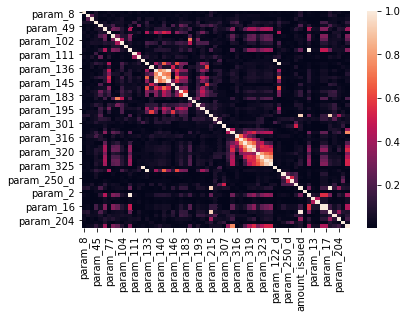

In [13]:
sns.heatmap(X[param_maybe_notcategorical].corr().abs())

In [43]:
# Заполнение пропусков

for col in param_maybe_notcategorical:
    X[col] = df[col].fillna(-999999)
#     median = X[col].median()
#     X_median = X[col].fillna(median)
#     X_zero = X[col].fillna(0)
#     if abs(2*roc_auc_score(y, X_median)-1) > abs(2*roc_auc_score(y, X_zero)-1):
#         X[col] = X_median
#     else:
#         X[col] = X_zero
#     median = X[col].median()
#     perc = np.percentile(X[col], 95)
#     slope=-(math.log(1/0.95-1)/(perc-median))
#     X[col] = X[col].map(lambda x: 1/(1+math.exp(-slope*(x-median))) if -slope*(x-median)<700 else 0 )
#     X[col] = np.log(X[col]- X[col].min()+0.001)
    
    
for col in param_maybe_categorical + list(param_list['object']):
    X[col] = X[col].astype(str).fillna('NA')
    X[col] = [text if (sum(X[col]==text)/X.shape[0])>0.02 else 'other' for text in list(X[col])] #/X.shape[0])>0.05 #>100

In [44]:
X.to_pickle('x.pkl')

In [135]:
X_copy = pd.read_pickle('x.pkl')

In [136]:
for col in param_maybe_categorical + list(param_list['object']):
    X[col] = X_copy[col]
for col in param_maybe_notcategorical:
    X[col] = df[col].fillna(-999999)

In [137]:
all_features = param_maybe_notcategorical +list(param_list['bool']) + param_maybe_categorical + list(param_list['object'])

In [138]:
categorical = list(param_list['bool']) + param_maybe_categorical + list(param_list['object'])

In [139]:
X_train, X_test, y_train, y_test = \
                                     model_selection.train_test_split( \
                                                    X[all_features], df[target], test_size=0.2, random_state=42)

In [140]:
cat_features_index = [i for i in range(len(all_features)) if all_features[i] in (categorical)]

In [141]:
model = catboost.CatBoostClassifier(learning_rate=0.01,
                                    iterations=1000,
                                    one_hot_max_size=256, 
                                    depth=6, 
                                    #rsm=0.98, 
                                    loss_function= 'Logloss', 
                                    eval_metric='AUC',
                                    use_best_model=True,
                                    #random_state=42
                                   )
# # Fit model
model.fit(X_train, y_train, cat_features_index,
         eval_set=(X_test, y_test) ,
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [142]:
y_pred = model.predict_proba(X_test)[:,1]#, y_test, cat_features)
print('Gini Catboost model на test = ', 2*roc_auc_score(y_test,y_pred)-1)

0.3207604269836031

In [146]:
# Отбор топ фичей по значимсти из модели Catboost

cat = pd.DataFrame(list(X_train), columns=['param'])
cat['fi'] = model.get_feature_importance()
cat = cat.sort_values('fi',ascending=False)
cat[cat['fi']>1]

,param,fi
61,param_204,4.245694
30,param_215,4.046505
59,param_46,2.840477
52,amount_issued,2.534784
60,param_47,2.145655
35,param_315,1.948516
63,param_314,1.879336
25,param_190,1.828538
23,param_182,1.744664
34,param_313,1.731970


In [147]:
top=cat[cat['fi']>1].param.values

In [148]:
topCat_cols = [col for col in top if col in categorical]
len(topCat_cols)

6

In [149]:
topNum_cols = [col for col in top if col not in categorical]
len(topNum_cols)

15

In [150]:
# Удаление скоррелированных менее значимых вещественных переменных из топа

X_corr = X_train[topNum_cols].corr().abs()

topNumCorr_col = []
for i in range(len(topNum_cols)-1):
    for j in range(i+1,len(topNum_cols)):
        if (X_corr[topNum_cols[i]][topNum_cols[j]]>0.75):
            topNumCorr_col += [topNum_cols[j]]
            
topNumNotCorr_col = [col for col in topNum_cols if col not in topNumCorr_col]

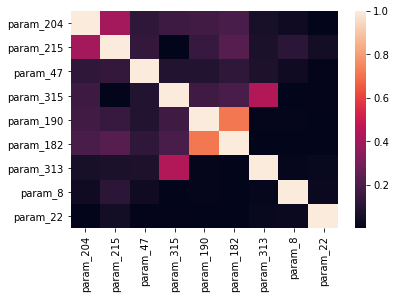

In [151]:
# Корреляция оставшихся вещественных переменных
sns.heatmap(X_train[topNumNotCorr_col].corr().abs())

In [152]:
X_numeric = X_train[topNumNotCorr_col]

In [153]:
X_train_cat = X_train[topCat_cols]

param_204


C:\Users\delte\Documents\тест_Авентус\woe.py:292: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = woe_fig.add_subplot(111)


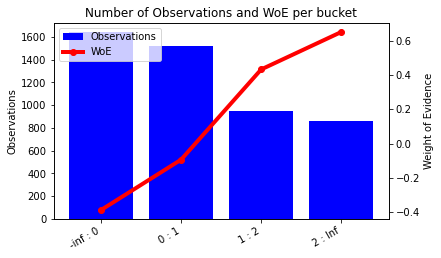

param_215


C:\Users\delte\Documents\тест_Авентус\woe.py:292: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = woe_fig.add_subplot(111)


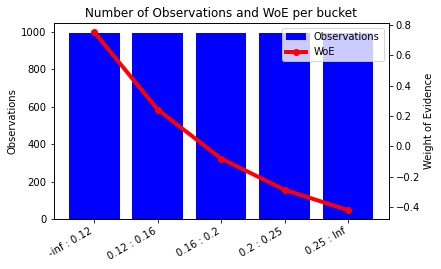

param_47


C:\Users\delte\Documents\тест_Авентус\woe.py:292: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = woe_fig.add_subplot(111)


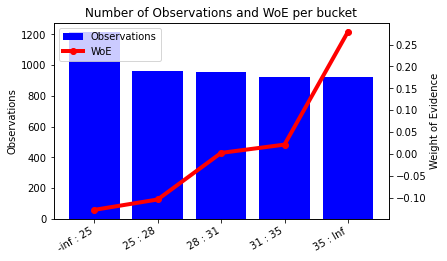

param_315


C:\Users\delte\Documents\тест_Авентус\woe.py:292: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = woe_fig.add_subplot(111)


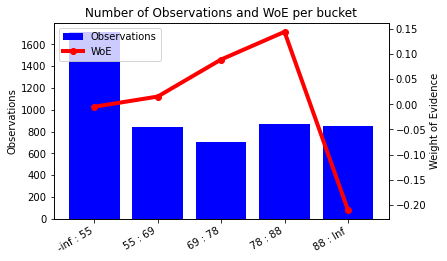

param_190


C:\Users\delte\Documents\тест_Авентус\woe.py:292: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = woe_fig.add_subplot(111)


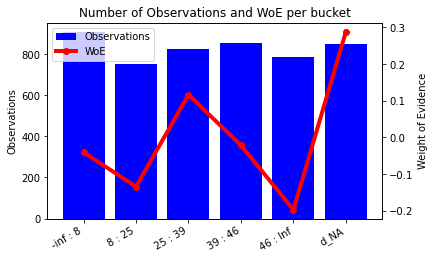

param_182


C:\Users\delte\Documents\тест_Авентус\woe.py:292: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = woe_fig.add_subplot(111)


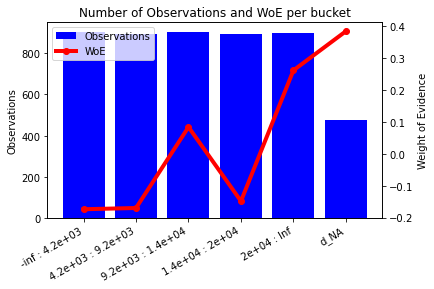

param_313


C:\Users\delte\Documents\тест_Авентус\woe.py:292: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = woe_fig.add_subplot(111)


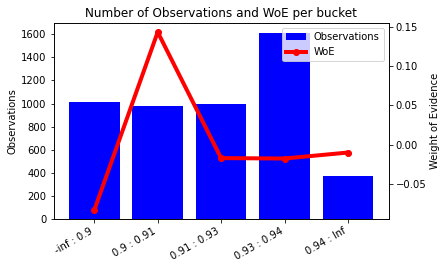

param_8


C:\Users\delte\Documents\тест_Авентус\woe.py:292: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = woe_fig.add_subplot(111)


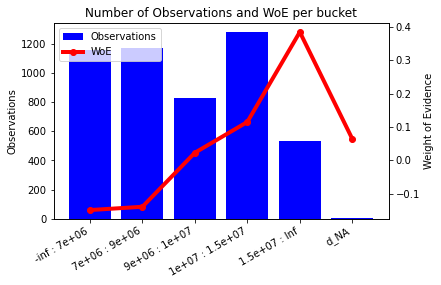

param_22


C:\Users\delte\Documents\тест_Авентус\woe.py:292: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = woe_fig.add_subplot(111)


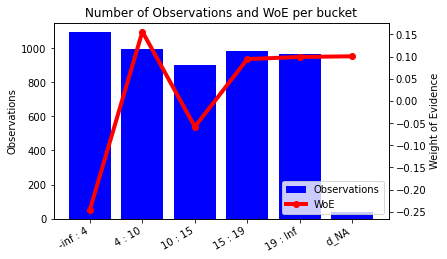

In [166]:
topWoe_cols =[]

for col in topNumNotCorr_col:
    print(col)
    if len(X_train[col].drop_duplicates())<10:
        qnt_num_ = 4
    else:
        qnt_num_ = 5
    woe = WoE(qnt_num=qnt_num_, spec_values={-999999: 'NA'})
    # Transform x1
    woe.fit(X_train[col], y_train)
    
    # Transform x2 using x1 transformation rules
    X_train[col+'_woe'] = woe.transform(X_train[col])['woe']
    X_test[col+'_woe'] = woe.transform(X_test[col])['woe']

    topWoe_cols += [col+'_woe'] 

    fig = woe.plot()
    plt.show(fig)

param_21


C:\Users\delte\Documents\тест_Авентус\woe.py:292: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = woe_fig.add_subplot(111)


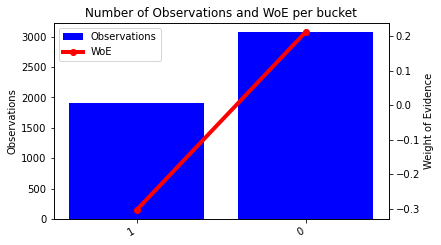

C:\Users\delte\Documents\тест_Авентус\woe.py:292: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = woe_fig.add_subplot(111)


param_6


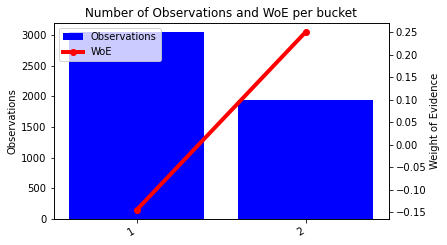

param_272


C:\Users\delte\Documents\тест_Авентус\woe.py:292: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = woe_fig.add_subplot(111)


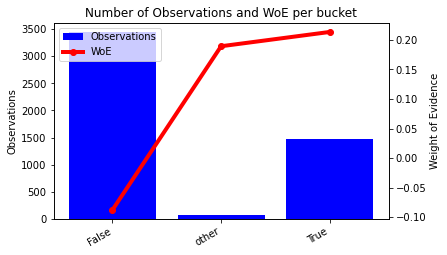

C:\Users\delte\Documents\тест_Авентус\woe.py:292: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = woe_fig.add_subplot(111)


param_222


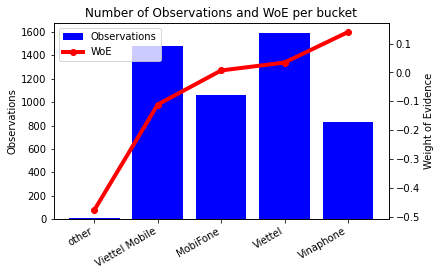

param_210


C:\Users\delte\Documents\тест_Авентус\woe.py:292: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = woe_fig.add_subplot(111)


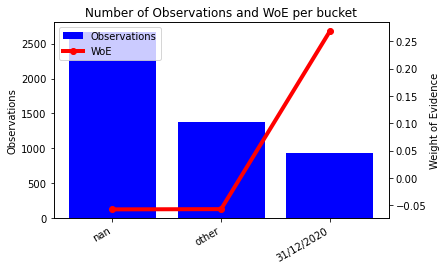

param_19


C:\Users\delte\Documents\тест_Авентус\woe.py:292: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = woe_fig.add_subplot(111)


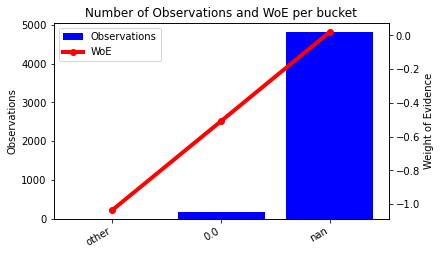

In [168]:
for col in topCat_cols:
    print(col)
    woe = WoE(v_type='d')
    # Transform x1
    woe.fit(X_train[col], y_train)
    # Transform x2 using x1 transformation rules
    X_train[col+'_woe'] = woe.transform(X_train[col])['woe']
    X_test[col+'_woe'] = woe.transform(X_test[col])['woe']

    topWoe_cols += [col+'_woe'] 
    
    fig = woe.plot()
    plt.show(fig)

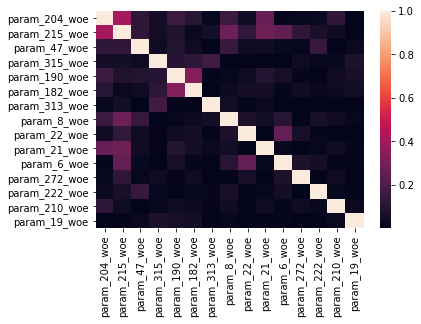

In [170]:
topWoe_cols
sns.heatmap(X_train[topWoe_cols].corr().abs())

In [183]:
X_train_mod=X_train[topWoe_cols]
X_test_mod=X_test[topWoe_cols]

optimizer_bln = LogisticRegression(penalty='l1',solver='liblinear')
optimizer_bln.fit(X_train_mod, y_train)

auc_zero_prob_bln = roc_auc_score(y_test, optimizer_bln.predict_proba(X_test_mod)[:,1])
print('test',2*auc_zero_prob_bln-1)

auc_zero_prob_bln = roc_auc_score(y_train, optimizer_bln.predict_proba(X_train_mod)[:,1])
print('train',2*auc_zero_prob_bln-1)

print('coef = ')
print(optimizer_bln.coef_)

test 0.3282298888522064
train 0.3349922748546519
coef = 
[[-0.62146331 -0.43802824 -0.53771238 -1.27772726 -0.4154037  -0.83996835
  -0.27769547 -0.46485988 -0.36428751 -0.52937779 -0.80979196 -0.83499619
  -0.61841249 -0.57851747 -1.03571423]]


In [177]:
log_reg = sm.Logit(y_train,X_train_mod).fit()
print(log_reg.summary()) 
ypred = log_reg.predict(X_train_mod[list(X_train_mod)]) 
auc_zero_prob_bln = roc_auc_score(y_train, ypred)
print('Gini train',2*auc_zero_prob_bln-1)
ypred = log_reg.predict(X_test_mod[list(X_train_mod)]) 
auc_zero_prob_bln = roc_auc_score(y_test, ypred)
print('Gini test',2*auc_zero_prob_bln-1)

Optimization terminated successfully.
         Current function value: 0.649325
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:             risk_event   No. Observations:                 4973
Model:                          Logit   Df Residuals:                     4958
Method:                           MLE   Df Model:                           14
Date:                Mon, 08 Feb 2021   Pseudo R-squ.:                 -0.1286
Time:                        17:42:14   Log-Likelihood:                -3229.1
converged:                       True   LL-Null:                       -2861.3
Covariance Type:            nonrobust   LLR p-value:                     1.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
param_204_woe    -0.5892      0.085     -6.922      0.000      -0.756      -0.422
param_215_woe    -0.

In [207]:
# Удаление статистически не значимой переменной 

log_reg = sm.Logit(y_train,X_train_mod.drop(columns='param_313_woe')).fit()
print(log_reg.summary()) 
ypred_train = log_reg.predict(X_train_mod[list(X_train_mod.drop(columns='param_313_woe'))]) 
auc_zero_prob_bln = roc_auc_score(y_train, ypred_train)
print('Gini train',2*auc_zero_prob_bln-1)
ypred = log_reg.predict(X_test_mod[list(X_train_mod.drop(columns='param_313_woe'))]) 
auc_zero_prob_bln = roc_auc_score(y_test, ypred)
print('Gini test',2*auc_zero_prob_bln-1)

Optimization terminated successfully.
         Current function value: 0.649446
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:             risk_event   No. Observations:                 4973
Model:                          Logit   Df Residuals:                     4959
Method:                           MLE   Df Model:                           13
Date:                Mon, 08 Feb 2021   Pseudo R-squ.:                 -0.1288
Time:                        18:36:23   Log-Likelihood:                -3229.7
converged:                       True   LL-Null:                       -2861.3
Covariance Type:            nonrobust   LLR p-value:                     1.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
param_204_woe    -0.5892      0.085     -6.922      0.000      -0.756      -0.422
param_215_woe    -0.

In [199]:
from sklearn.metrics import precision_recall_curve, accuracy_score

In [231]:
Y_train = pd.DataFrame()
Y_train['y'] = y_train
Y_train['y_pred'] = ypred_train

cutOff = np.quantile(ypred_train, 1-y_train.mean())
print(cutOff)

Y_train['y_label'] = (Y_train['y_pred']>cutOff).astype('int')
print('accuracy on train = ',mean(Y_train['y_label'] == Y_train['y']))

0.5885209332480776
accuracy on train =  0.6826865071385482


In [236]:
Y_test = pd.DataFrame()
Y_test['y'] = y_test
Y_test['y_pred'] = ypred

Y_test['y_label'] = (Y_test['y_pred']>cutOff).astype('int')

print('accuracy on test = ',mean(Y_test['y_label'] == Y_test['y']))

accuracy on test =  0.6889067524115756


In [234]:
prec, rec, _ = precision_recall_curve(y_test, ypred)
F1 = 2 * (prec * rec) / (prec + rec)
F1

array([0.40206186, 0.40103159, 0.40129032, ..., 0.01273885, 0.00638978,
       0.        ])

In [237]:
max(F1)

0.4691075514874141

In [198]:
rec[F1==max(F1)]

array([0.65705128])

In [235]:
prec[F1==max(F1)]

array([0.36476868])